<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-and-Prepare-Player-Data" data-toc-modified-id="Load-and-Prepare-Player-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load and Prepare Player Data</a></span></li><li><span><a href="#Create-Features-and-Labels-from-Training/Testing-Datasets" data-toc-modified-id="Create-Features-and-Labels-from-Training/Testing-Datasets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create Features and Labels from Training/Testing Datasets</a></span></li><li><span><a href="#Optimizing-and-Fitting-a-Player-Classifier-Model" data-toc-modified-id="Optimizing-and-Fitting-a-Player-Classifier-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimizing and Fitting a Player Classifier Model</a></span></li><li><span><a href="#Validating-the-Model-with-Test-Data" data-toc-modified-id="Validating-the-Model-with-Test-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Validating the Model with Test Data</a></span></li><li><span><a href="#Predicting-Rookie-Player-Similarity" data-toc-modified-id="Predicting-Rookie-Player-Similarity-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predicting Rookie Player Similarity</a></span></li><li><span><a href="#Example-Player-Comparison-Plots" data-toc-modified-id="Example-Player-Comparison-Plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Example Player Comparison Plots</a></span></li></ul></div>

In [2]:
# Import modules and packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
%matplotlib inline

In [3]:
# Set seaborn plot style
sns.set_style("whitegrid")

# Load and Prepare Player Data

In [99]:
# Load comprehensive dataset of player stats
dfp = pd.read_csv('../CompleteNBAPlayerStats.csv')
dfp

,name,pos,team,year,GP,GS,height,weight,college,country,...,2PR,3PR,FG_FREQ_RIM,FG_FREQ_MR_AND_PT,FG_FREQ_MR,FG_FREQ_CORNERS,FG_FREQ_AB,FG_FREQ_01DRIB,FG_FREQ_GT1DRIB,FG_FREQ_CANDS
0,Andre Miller,PG,TOT,2016,39.0,4.0,74.0,200.0,Utah,USA,...,0.925000,0.075000,0.477844,0.441086,0.257300,0.000000,0.000000,0.000000,0.000000,0.073514
1,Dirk Nowitzki,PF,DAL,2016,75.0,75.0,83.0,237.0,None,Germany,...,0.693966,0.306034,0.081150,0.608622,0.520710,0.033812,0.033812,0.000000,0.000000,0.540997
2,Dirk Nowitzki,PF,DAL,2017,54.0,54.0,83.0,237.0,None,Germany,...,0.692308,0.307692,0.071770,0.622010,0.534290,0.023923,0.023923,0.853270,0.000000,0.606061
3,Dirk Nowitzki,C,DAL,2018,77.0,77.0,83.0,237.0,None,Germany,...,0.554404,0.445596,0.050607,0.506073,0.435223,0.030364,0.030364,0.890688,0.000000,0.668016
4,Dirk Nowitzki,PF,DAL,2019,51.0,20.0,83.0,237.0,None,Germany,...,0.455357,0.544643,0.013575,0.434389,0.366516,0.054299,0.054299,0.923077,0.000000,0.733032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,Rui Hachimura,PF,WAS,2020,25.0,25.0,80.0,230.0,Gonzaga,Japan,...,0.843750,0.156250,0.443836,0.402740,0.254795,0.057534,0.057534,0.682192,0.304110,0.230137
1743,Sekou Doumbouya,SF,DET,2020,14.0,7.0,80.0,230.0,None,Guinea,...,0.639241,0.360759,0.374665,0.178412,0.035682,0.196253,0.196253,0.642284,0.000000,0.303301
1744,Terence Davis,SG,TOR,2020,39.0,1.0,76.0,201.0,None,USA,...,0.435065,0.564935,0.345926,0.091033,0.036413,0.145653,0.145653,0.710059,0.291306,0.473373
1745,Ty Jerome,PG,PHX,2020,10.0,0.0,77.0,195.0,Virginia,USA,...,0.592814,0.407186,0.183175,0.407056,0.162822,0.020353,0.020353,0.508820,0.488467,0.386703


In [109]:
# Establish a minimum number of games played and minutes per game (MPG)
min_num_games = 40
min_MPG = 10

# Apply cuts on GP/MPG/other parameters
df = dfp.copy()
#df = df[df.GP > min_num_games]
#df = df[df.MPG > min_MPG]

# Group and average rows with duplicate player-seasons
df = df[df.year < 2020].groupby(['name', 'year'], as_index=False).mean()

In [124]:
# Create separate dataframes for established players and rookies

df_vets = df[df["name"].isin(df["name"].value_counts()[df["name"].value_counts() == 4].index)]
df_train = df_vets[df_vets.year < 2019]
#df_train = df_train.groupby(['name'], as_index=False).mean()
df_test = df_vets[df_vets.year == 2019]

df_rooks = df[df["name"].isin(df["name"].value_counts()[df["name"].value_counts() == 1].index)]
df_rooks = df_rooks[df_rooks.year == 2019]

#print(df_train)
#print(df_test)
#print(df_rooks)

print("Using a training dataset of size:", len(df_train))
print("Using a test dataset of size:", len(df_test))


Using a training dataset of size: 543
Using a test dataset of size: 181


# Create Features and Labels from Training/Testing Datasets

In [125]:
# Specify which dataframe columns to use as model features
feature_labels = ['height', 'weight', 'FG_FREQ_RIM', 'FG_FREQ_MR_AND_PT', 'FG_FREQ_CORNERS', 'FG_FREQ_AB', 'FG_FREQ_CANDS', 'FTR', 'ASTR', 'TOV_PH', 'ORR', 'DRR', 'BLK_PH', 'STL_PH', 'DFGP_PG']

# Create input features and target labels (player names) for test data
test_labels = df_test[["name"]]
test_features = df_test[feature_labels]

# Create matching training dataset using only veterans who are still in the NBA 
# (and thus have available training data)
train_labels = df_train[["name"]]
train_features = df_train[feature_labels]

# Scale features which will be used in model fitting
scale_train = StandardScaler().fit(train_features)
train_features = scale_train.transform(train_features)
scale_test = StandardScaler().fit(test_features)
test_features = scale_test.transform(test_features)

# Optimizing and Fitting a Player Classifier Model

In [126]:
# Perform a grid search to optimize parameters for Support Vector Classification
gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
Cs = [1, 10, 100, 1000, 10000, 100000, 1000000]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(svm.SVC(), param_grid)
grid_search.fit(train_features, train_labels.values.ravel())
grid_search.best_params_
print(grid_search.best_params_)

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 100, 'gamma': 0.01}


In [127]:
# Instantiate classifier model using optimized parameters 
# and fit the model to the training dataset
clf = svm.SVC(gamma=0.01, C=100)
clf.fit(train_features, train_labels.values.ravel())

#xgb = XGBClassifier()
#xgb.fit(train_features, train_labels.values.ravel())

#rfc = RandomForestClassifier()
#rfc.fit(train_features, train_labels.values.ravel())


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Validating the Model with Test Data

In [128]:
# Implement the model on test data (veteran stats from the last full season) 
# and classify/predict which player is which based on those recent stats
y_pred = clf.predict(test_features)
#y_pred = xgb.predict(test_features)
#y_pred = rfc.predict(test_features)
for i,pred in enumerate(y_pred):
    print("Predicted that Player", test_labels.name.values[i], "is Player", pred)


Predicted that Player Aaron Gordon is Player Aaron Gordon
Predicted that Player Al Horford is Player Al Horford
Predicted that Player Al-Farouq Aminu is Player DeMarre Carroll
Predicted that Player Alec Burks is Player Evan Fournier
Predicted that Player Alex Len is Player Derrick Favors
Predicted that Player Allen Crabbe is Player Allen Crabbe
Predicted that Player Amir Johnson is Player Nikola Jokic
Predicted that Player Andre Drummond is Player Andre Drummond
Predicted that Player Andre Iguodala is Player Andre Iguodala
Predicted that Player Andrew Wiggins is Player Andrew Wiggins
Predicted that Player Anthony Davis is Player Anthony Davis
Predicted that Player Anthony Tolliver is Player Anthony Tolliver
Predicted that Player Austin Rivers is Player Austin Rivers
Predicted that Player Avery Bradley is Player E'Twaun Moore
Predicted that Player Blake Griffin is Player Blake Griffin
Predicted that Player Bobby Portis is Player Bobby Portis
Predicted that Player Bojan Bogdanovic is Pla

In [158]:
# Calculate rough accuracy of the test dataset by matching predictions with test labels
print("Classified veteran players with an accuracy of", np.sum(test_labels.name.values==y_pred)*100./(len(y_pred)*1.), "%")

Classified veteran players with an accuracy of 71.2707182320442 %


# Predicting Rookie Player Similarity

In [130]:
# Format rookie dataset for input into the classifier and 
# attempt to classify rookies by their most similar veteran counterpart
pred_labels = df_rooks[["name"]]
pred_features = df_rooks[feature_labels]

scale_pred = StandardScaler().fit(pred_features)
pred_features = scale_pred.transform(pred_features)
rook_pred = clf.predict(pred_features)

for i,pred in enumerate(rook_pred):
    print("Predicted that Rookie", pred_labels.name.values[i], "is similar to Player:", pred)
    

Predicted that Rookie Aaron Holiday is similar to Player: Raymond Felton
Predicted that Rookie Alfonzo McKinnie is similar to Player: Jonas Jerebko
Predicted that Rookie Boban Marjanovic is similar to Player: Alex Len
Predicted that Rookie Bonzie Colson is similar to Player: PJ Tucker
Predicted that Rookie Brandon Sampson is similar to Player: Gary Harris
Predicted that Rookie Bruce Brown is similar to Player: Tyler Johnson
Predicted that Rookie Cameron Reynolds is similar to Player: JR Smith
Predicted that Rookie Chandler Hutchison is similar to Player: Alec Burks
Predicted that Rookie Cheick Diallo is similar to Player: Willie Cauley-Stein
Predicted that Rookie Christian Wood is similar to Player: Alex Len
Predicted that Rookie DJ Wilson is similar to Player: Trey Lyles
Predicted that Rookie Daniel Hamilton is similar to Player: Evan Turner
Predicted that Rookie Daryl Macon is similar to Player: Goran Dragic
Predicted that Rookie De'Aaron Fox is similar to Player: John Wall
Predicted

# Example Player Comparison Plots

In [131]:
# Combine veteran and rookie datasets for ease of comparison plotting
frames = [df_vets, df_rooks]
df_comb = pd.concat(frames)

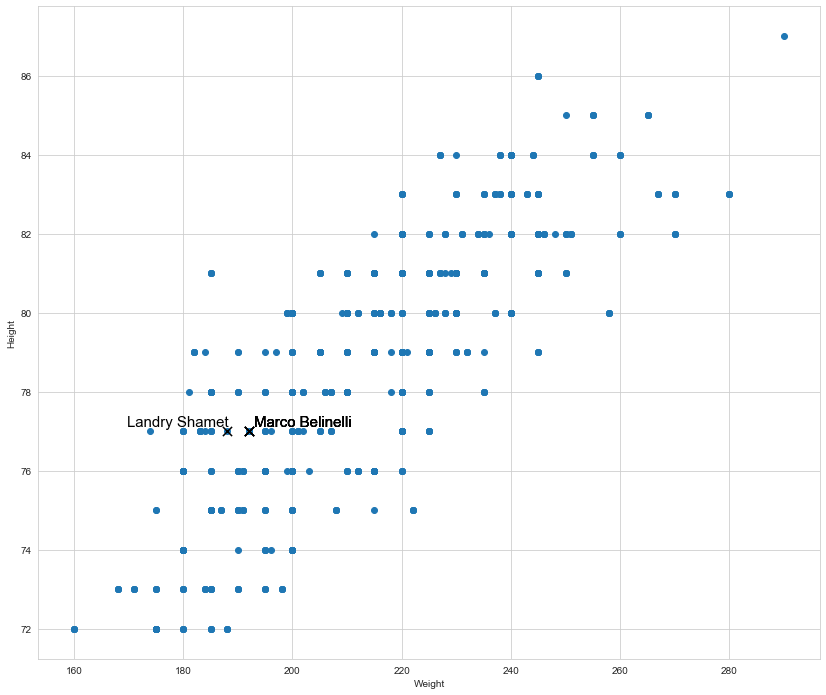

In [149]:
# Compare physical attributes (weight, height) of the players 

fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Weight")
plt.ylabel("Height")
plt.scatter(df_comb.weight, df_comb.height)
for i, txt in enumerate(df_comb.name.values):
    if txt == "Landry Shamet":
        plt.scatter(df_comb.weight.values[i], df_comb.height.values[i], marker='x', c='black', s=85)
        ax.annotate(txt, (df_comb.weight.values[i], df_comb.height.values[i]), color='black', textcoords='offset points', xytext=(-100, 5), size=15)
    if txt == "Marco Belinelli":
        plt.scatter(df_comb.weight.values[i], df_comb.height.values[i], marker='x', c='black', s=85)
        ax.annotate(txt, (df_comb.weight.values[i], df_comb.height.values[i]), color='black', textcoords='offset points', xytext=(5, 5), size=15)
        

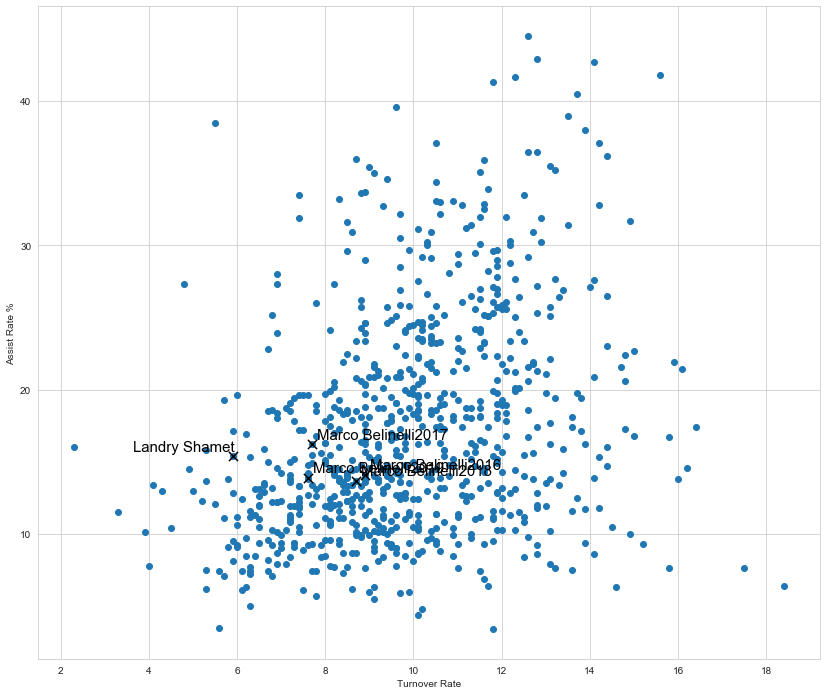

In [153]:
# Compare how often player possessions result in an assist or turnover

fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Turnover Rate")
plt.ylabel("Assist Rate %")
plt.scatter(df_comb[df_comb.TOR<30].TOR, df_comb[df_comb.TOR<30].ASTR)
for i, txt in enumerate(df_comb[df_comb.TOR<30].name.values):
    if txt == "Landry Shamet":
        plt.scatter(df_comb[df_comb.TOR<30].TOR.values[i], df_comb[df_comb.TOR<30].ASTR.values[i], marker='x', c='black', s=85)
        ax.annotate(txt, (df_comb[df_comb.TOR<30].TOR.values[i], df_comb[df_comb.TOR<30].ASTR.values[i]), color='black', textcoords='offset points', xytext=(-100, 5), size=15)
    if txt == "Marco Belinelli":
        plt.scatter(df_comb[df_comb.TOR<30].TOR.values[i], df_comb[df_comb.TOR<30].ASTR.values[i], marker='x', c='black', s=85)
        ax.annotate(txt + str(df_comb[df_comb.TOR<30].year.values[i]), (df_comb[df_comb.TOR<30].TOR.values[i], df_comb[df_comb.TOR<30].ASTR.values[i]), color='black', textcoords='offset points', xytext=(5, 5), size=15)


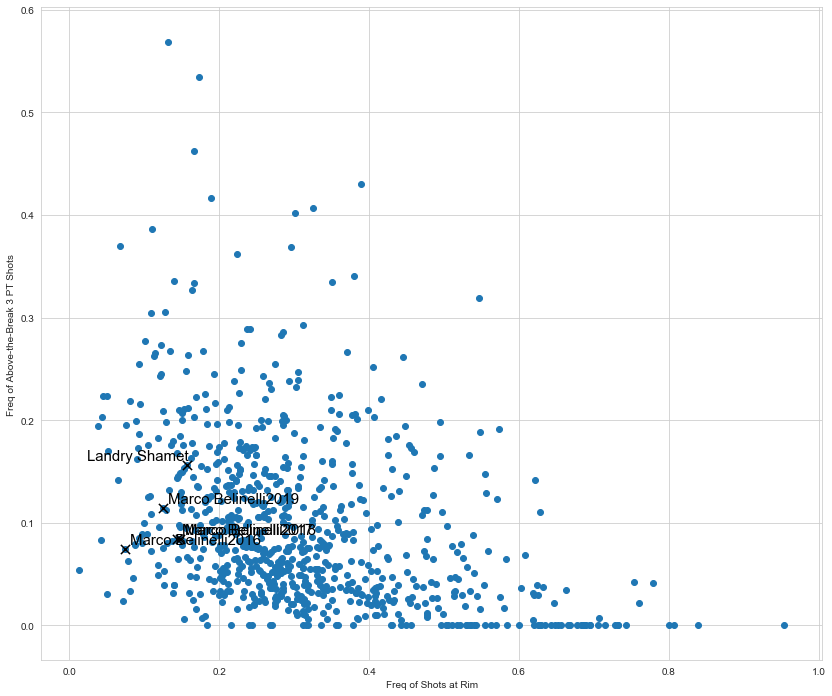

In [156]:
# Compare ratio of shots taken at the rim (dunks, layups)
# and ratio of 3-pointers taken above the break

fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Freq of Shots at Rim")
plt.ylabel("Freq of Above-the-Break 3 PT Shots")
plt.scatter(df_comb['FG_FREQ_RIM'], df_comb['FG_FREQ_AB'])
for i, txt in enumerate(df_comb.name.values):
    if txt == "Landry Shamet":
        plt.scatter(df_comb['FG_FREQ_RIM'].values[i], df_comb['FG_FREQ_AB'].values[i], marker='x', c='black', s=85)
        ax.annotate(txt, (df_comb['FG_FREQ_RIM'].values[i], df_comb['FG_FREQ_AB'].values[i]), color='black', textcoords='offset points', xytext=(-100, 5), size=15)
    if txt == "Marco Belinelli":
        plt.scatter(df_comb['FG_FREQ_RIM'].values[i], df_comb['FG_FREQ_AB'].values[i], marker='x', c='black', s=85)
        ax.annotate(txt + str(df_comb.year.values[i]), (df_comb['FG_FREQ_RIM'].values[i], df_comb['FG_FREQ_AB'].values[i]), color='black', textcoords='offset points', xytext=(5, 5), size=15)
        

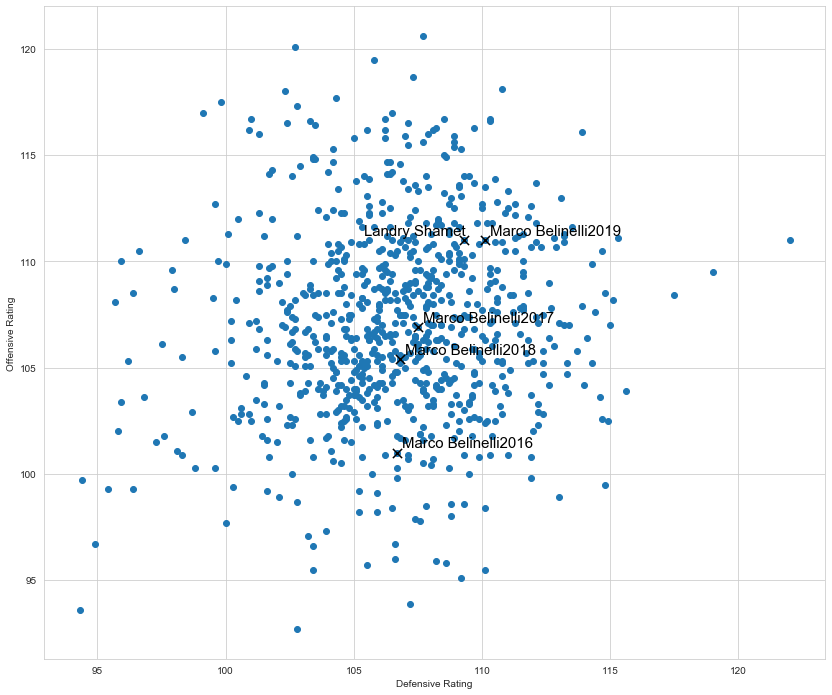

In [157]:
# Compare offensive and defensive ratings for the example players,
# to see how comparable they are in a non-feature metric

fig, ax = plt.subplots(figsize=(14, 12))
plt.xlabel("Defensive Rating")
plt.ylabel("Offensive Rating")
plt.scatter(df_comb.DEFRTG.values, df_comb.OFFRTG.values)
#plt.ylim(45, 150)
for i, txt in enumerate(df_comb.name.values):
    if txt == "Landry Shamet":
        plt.scatter(df_comb.DEFRTG.values[i], df_comb.OFFRTG.values[i], marker='x', c='black', s=85)
        ax.annotate(txt, (df_comb.DEFRTG.values[i], df_comb.OFFRTG.values[i]), color='black', textcoords='offset points', xytext=(-100, 5), size=15)
    if txt == "Marco Belinelli":
        plt.scatter(df_comb.DEFRTG.values[i], df_comb.OFFRTG.values[i], marker='x', c='black', s=85)
        ax.annotate(txt + str(df_comb.year.values[i]), (df_comb.DEFRTG.values[i], df_comb.OFFRTG.values[i]), color='black', textcoords='offset points', xytext=(5, 5), size=15)
        